In [164]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split

In [2]:
# Read the data
DATA_FILENAME = "hbonddata.xlsx"
dataframe_raw = pd.read_excel(DATA_FILENAME,sheet_name='data')
dataframe_raw = dataframe_raw.filter(items=['Acid', 'Base', 'Agroup', 'Aeneg', 'Asize', 'Beneg', 'Bsize', 'Δν', '-ΔH (kJ mol-1)'])
# Drop the rows with NANs. 
dataframe_raw = dataframe_raw.dropna(axis=0, how = 'any')
dataframe_raw.head()

,Acid,Base,Agroup,Aeneg,Asize,Beneg,Bsize,Δν,-ΔH (kJ mol-1)
0,(CCl3)2CHOH,Acetonitrile,COH,3.41,150,2.90,166.0,211.0,22.6
1,(CH2Cl)2CHOH,Acetonitrile,COH,3.41,150,2.90,166.0,102.0,14.2
2,(CHCl2)2CHOH,Acetonitrile,COH,3.41,150,2.90,166.0,174.0,19.8
3,Acetic acid,Pyridine,COOH,3.41,150,2.90,166.0,1000.0,40.0
4,Acetic acid,Dimethyl sulfoxide,COOH,3.41,150,3.41,150.0,840.0,33.5


In [3]:
# Rename the columns
dataframe_raw.rename(columns={'-ΔH (kJ mol-1)': 'ΔH'}, inplace =True)
dataframe_raw.head()

,Acid,Base,Agroup,Aeneg,Asize,Beneg,Bsize,Δν,ΔH
0,(CCl3)2CHOH,Acetonitrile,COH,3.41,150,2.90,166.0,211.0,22.6
1,(CH2Cl)2CHOH,Acetonitrile,COH,3.41,150,2.90,166.0,102.0,14.2
2,(CHCl2)2CHOH,Acetonitrile,COH,3.41,150,2.90,166.0,174.0,19.8
3,Acetic acid,Pyridine,COOH,3.41,150,2.90,166.0,1000.0,40.0
4,Acetic acid,Dimethyl sulfoxide,COOH,3.41,150,3.41,150.0,840.0,33.5


In [4]:
# Check the info of the data
dataframe_raw.describe()

,Aeneg,Asize,Beneg,Bsize,Δν,ΔH
count,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000
mean,3.238428,155.789308,3.172390,157.122642,317.967614,19.464534
std,0.325150,10.909563,0.303832,8.586949,350.151747,11.840464
min,2.480000,150.000000,2.040000,150.000000,1.000000,0.700000
25%,3.410000,150.000000,2.900000,150.000000,109.192487,10.632760
50%,3.410000,150.000000,3.410000,150.000000,218.741953,17.600000
75%,3.410000,150.000000,3.410000,166.000000,364.500000,25.104000
max,3.410000,189.000000,3.410000,177.000000,2300.000000,67.000000


In [5]:
your_name = "Stcike sarpherise Lei h bond project" # at least 5 characters
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.85*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.Δν = dataframe.Δν * ord(rand_str[1])/100.
    # scale target
    dataframe.ΔH = dataframe.ΔH * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['Acid','Base'], axis=1)
    return dataframe

dataframe = customize_dataset(dataframe_raw, your_name)
dataframe

,Agroup,Aeneg,Asize,Beneg,Bsize,Δν,ΔH
266,COH,3.41,150,3.41,150.0,117.160000,12.177000
79,COH,3.41,150,2.90,166.0,280.720000,12.870000
324,HOH,3.41,150,2.90,166.0,480.240000,32.076000
241,NH,2.90,166,2.90,166.0,498.800000,24.453000
156,PhOH,3.41,150,3.41,150.0,138.955647,17.355650
...,...,...,...,...,...,...,...
171,COH,3.41,150,2.90,166.0,421.080000,26.532000
172,PhOH,3.41,150,2.90,166.0,951.200000,37.719000
92,COH,3.41,150,2.90,166.0,350.260170,17.024278
67,PhOH,3.41,150,3.41,150.0,392.080000,33.165000


In [6]:
input_cols = ['Aeneg', 'Asize', 'Beneg', 'Bsize', 'Δν']
categorical_cols = ['Agroup']
output_cols = ['ΔH']

In [7]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[  3.41      , 150.        ,   3.41      , 150.        ,
         117.16      ],
        [  3.41      , 150.        ,   2.9       , 166.        ,
         280.72      ],
        [  3.41      , 150.        ,   2.9       , 166.        ,
         480.24      ],
        ...,
        [  3.41      , 150.        ,   2.9       , 166.        ,
         350.26016967],
        [  3.41      , 150.        ,   3.41      , 150.        ,
         392.08      ],
        [  3.41      , 150.        ,   3.41      , 150.        ,
         444.28      ]]),
 array([[12.177    ],
        [12.87     ],
        [32.076    ],
        [24.453    ],
        [17.3556504],
        [ 4.158    ],
        [13.3791768],
        [40.593168 ],
        [ 6.633    ],
        [14.49756  ],
        [39.35052  ],
        [ 7.92     ],
        [12.7992744],
        [45.149544 ],
        [12.1779504],
        [38.107872 ],
        [43.906896 ],
        [31.0662   ],
        [14.949    ],
        [15.4088352],
        [ 8

In [24]:
inputs = torch.Tensor(inputs_array)
targets = torch.Tensor(targets_array)

dataset = TensorDataset(inputs, targets)
train_ds, val_ds = random_split(dataset, [225, 45])
batch_size = 75

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [285]:
import random
input_size = len(input_cols)
output_size = len(output_cols)
H = 30
criterion = nn.MSELoss(reduction='sum')
p = 0.005
class HbondModel(nn.Module):
    def __init__(self):
        super().__init__()
#         self.linear = nn.Linear(input_size, output_size)                  # fill this (hint: use input_size & output_size defined above)
        self.input_linear = nn.Linear(input_size, H)
        self.middle_linear = nn.Linear(H, H)
        self.output_linear = nn.Linear(H, output_size)
        self.dropout = nn.Dropout(p)
               
    def forward(self, xb):
        out = F.relu(self.input_linear(xb))
        out = F.relu(self.middle_linear(out))
        out = self.dropout(self.output_linear(out))
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = criterion(out, targets)                         # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = criterion(out, targets)                           # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [276]:
model = HbondModel()

# Eval algorithm
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

result = evaluate(model, val_loader)
print(result)

{'val_loss': 40183.9453125}


In [277]:
# Fitting algorithm
def fit(epochs, lr, momentum, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [286]:
i=0
while i < 5:
    epochs = 90
    lr = 1e-7
    momentum=0.2
    history1 = fit(epochs, lr, momentum, model, train_loader, val_loader)
    i+=1

Epoch [20], val_loss: 577.4976
Epoch [40], val_loss: 573.5722
Epoch [60], val_loss: 627.7725
Epoch [80], val_loss: 598.5545
Epoch [90], val_loss: 602.9419
Epoch [20], val_loss: 579.4686
Epoch [40], val_loss: 611.1249
Epoch [60], val_loss: 607.8699
Epoch [80], val_loss: 572.8987
Epoch [90], val_loss: 572.8241
Epoch [20], val_loss: 571.1283
Epoch [40], val_loss: 570.9821
Epoch [60], val_loss: 692.7260
Epoch [80], val_loss: 590.5250
Epoch [90], val_loss: 569.9241
Epoch [20], val_loss: 2248.2275
Epoch [40], val_loss: 574.8089
Epoch [60], val_loss: 570.2559
Epoch [80], val_loss: 575.4307
Epoch [90], val_loss: 569.6755
Epoch [20], val_loss: 582.5005
Epoch [40], val_loss: 943.0065
Epoch [60], val_loss: 575.3466
Epoch [80], val_loss: 572.7925
Epoch [90], val_loss: 574.3060


In [287]:
i=0
while i < 2:
    epochs = 70
    momentum=0.1
    lr = 1e-8
    history1 = fit(epochs, lr, momentum, model, train_loader, val_loader)
    i+=1

Epoch [20], val_loss: 574.8033
Epoch [40], val_loss: 573.9048
Epoch [60], val_loss: 573.7420
Epoch [70], val_loss: 2132.5854
Epoch [20], val_loss: 1066.8490
Epoch [40], val_loss: 573.6858
Epoch [60], val_loss: 573.4252
Epoch [70], val_loss: 573.1111


In [288]:
# Train repeatdly until have a 'good' val_loss
i=0
while i < 2:
    epochs = 20
    momentum=0.1
    lr = 1e-9
    history1 = fit(epochs, lr, momentum, model, train_loader, val_loader)
    i+=1

Epoch [20], val_loss: 573.3152
Epoch [20], val_loss: 573.3687


In [289]:
# Prediction Algorithm
def validation(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)
    return prediction

# Testing the model with some samples
input, target = val_ds[0]
validation(input, target, model)

Input: tensor([  2.4800, 177.0000,   3.4100, 150.0000, 221.5600])
Target: tensor([18.6120])
Prediction: tensor([16.9788])


tensor([16.9788])

In [290]:
val_value, target = val_ds[:]
predictions = validation(val_value, target, model)

Input: tensor([[   2.4800,  177.0000,    3.4100,  150.0000,  221.5600],
        [   3.4100,  150.0000,    2.9000,  166.0000,  643.8000],
        [   2.9000,  166.0000,    2.3600,  177.0000,   17.4000],
        [   3.4100,  150.0000,    2.9000,  166.0000,  897.8400],
        [   3.4100,  150.0000,    3.4100,  150.0000,  227.3600],
        [   3.4100,  150.0000,    3.4100,  150.0000,  309.7200],
        [   3.4100,  150.0000,    3.4100,  150.0000,  357.2800],
        [   2.9000,  166.0000,    3.4100,  150.0000,  303.9200],
        [   3.4100,  150.0000,    2.9000,  166.0000,  324.8000],
        [   3.4100,  150.0000,    3.4100,  150.0000,  381.9938],
        [   3.4100,  150.0000,    3.4100,  150.0000,  138.9556],
        [   3.4100,  150.0000,    3.4100,  150.0000,  325.9600],
        [   3.1000,  182.0000,    2.3600,  177.0000,   84.6800],
        [   2.9000,  166.0000,    2.9000,  166.0000,   89.3200],
        [   3.4100,  150.0000,    3.4100,  150.0000,  572.2981],
        [   3.4100

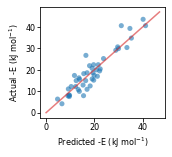

In [295]:
a = torch.linspace(0,47,20)
b = a
fig = plt.figure(figsize=(2.28,2.025))
ax = fig.add_axes([0.18, 0.21, 0.76, 0.76])
ax.scatter(predictions,target, c='tab:blue', s =26, alpha = 0.6, edgecolors='none')
ax.plot(a,b, color='tab:red', alpha = 0.6)
ax.tick_params(axis='x', pad=1.2, labelsize= 8)
ax.tick_params(axis='y', pad=1.2, labelsize= 8)
ax.set_xlabel('Predicted -E (kJ mol$^{-1}$)', fontsize=8)
ax.set_ylabel('Actual -E (kJ mol$^{-1}$)', fontsize=8)
plt.savefig('modeleva4.png',dpi=600)
plt.show()

In [264]:
# Prediction Algorithm
def predict(values, model):
    inputs = values.unsqueeze(0)
    predictions = model(inputs)
    prediction = predictions[0].detach()
    print("The input values are:", inputs)
    print("The H bond energy is:", prediction, 'kJ/mol')
    return prediction

In [292]:
values = torch.tensor([2.9, 166, 2.74, 204, 145])
predict(values, model)

The input values are: tensor([[  2.9000, 166.0000,   2.7400, 204.0000, 145.0000]])
The H bond energy is: tensor([13.6209]) kJ/mol


tensor([13.6209])